### Least Squares

##### Standard Problem:
$$
\begin{aligned}
\min_{x} \quad & \lVert x \rVert_2^2 \\
\textrm{s.t.} \quad & Ax = b
\end{aligned}
$$

##### Lagrangian:
$$
\begin{aligned}
\mathcal{L}(x, \lambda) = \min_{x} \max_{\lambda} \quad & x^{\top}x + \lambda^{\top} (Ax - b)
\end{aligned}
$$

##### Analytical Solution
$$
\begin{aligned}
\frac{\partial}{\partial \lambda} \rightarrow & Ax^\ast = b (1) \\
\frac{\partial}{\partial x} \rightarrow & 2x^\ast + A^\top \lambda^\ast = 0 \\
& x^\ast = - \frac{1}{2}A^\top\lambda^\ast (2)
\end{aligned}
$$

Replace $x^\ast$ in $(1)$
$$
\begin{aligned}
A( - \frac{1}{2}A^\top\lambda^\ast) & = b \\
 - \frac{1}{2}AA^\top\lambda^\ast & = b \\
 \lambda^\ast = -2(AA^\top)^{-1}b
\end{aligned}
$$

Replace $\lambda^\ast$ in $(2)$
$$
x^\ast = A^\top(AA^\top)^{-1}b
$$

In [20]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
from typing import Tuple

import cooper
import matplotlib.pyplot as plt
import torch

from cooper import CMPState, ConstraintGroup, ConstraintState
from cooper.optim import SimultaneousConstrainedOptimizer, ConstrainedOptimizer

from torch.utils.data import Dataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class LinearSystem(Dataset):
    def __init__(self, A: torch.Tensor, b: torch.Tensor):
        self.A = A
        self.b = b

    def __len__(self):
        return self.A.shape[0]

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.A[index], self.b[index], index


class LeastSquares(cooper.ConstrainedMinimizationProblem):
    def __init__(self, eq_group: ConstraintGroup) -> None:
        self.eq_group = eq_group
        super().__init__()

    def compute_cmp_state(
            self, x: torch.Tensor, A: torch.Tensor, b: torch.Tensor, indices: torch.Tensor
        ) -> CMPState:

        loss = torch.linalg.norm(x)**2
        violations = torch.mm(A, x) - b
        self.eq_group.state = ConstraintState(
            violation=violations, constraint_features=indices
        )

        return CMPState(loss=loss, observed_constraints=[self.eq_group])

In [22]:
def prepare_data(
    n_vars: int,
    n_eqs: int,
    batch_size: int,
    primal_lr: float,
    dual_lr: float
) -> tuple:

    A = torch.rand(size=(n_eqs, n_vars))
    b = torch.rand(size=(n_eqs, 1))

    x_optim = torch.mm(A.T, torch.mm(torch.linalg.inv(torch.mm(A, A.T)), b))

    linear_system = LinearSystem(A, b)
    ls_loader = DataLoader(linear_system, batch_size=batch_size)

    eq_group = ConstraintGroup(
        constraint_type="eq", shape=A.shape[0], dtype=torch.float16, device=A.device, is_sparse=True
    )

    x = torch.nn.Parameter(torch.rand(n_vars, 1))

    primal_optimizer = torch.optim.SGD([x], lr=primal_lr)
    dual_optimizer = torch.optim.SGD([eq_group.multiplier.weight], lr=dual_lr)

    optimizer = SimultaneousConstrainedOptimizer(
        constraint_groups=eq_group,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )

    cmp = LeastSquares(eq_group=eq_group)

    return x, x_optim, eq_group, ls_loader, optimizer, cmp


def optimization_process(
    n_iter: int,
    ls_loader: DataLoader,
    optimizer: ConstrainedOptimizer,
    cmp: cooper.ConstrainedMinimizationProblem,
    x: torch.Tensor,
    x_optim: torch.Tensor,
    eq_group: ConstraintGroup,
) -> dict:

    state_history = {}
    for i in range(n_iter):
        for sampled_A, sampled_b, indices in ls_loader:
            optimizer.zero_grad()
            cmp_state = cmp.compute_cmp_state(x, sampled_A, sampled_b, indices)
            _ = cmp_state.populate_lagrangian()
            cmp_state.backward()
            optimizer.step()

        state_history[i] = {
            "loss": deepcopy(cmp_state.loss.data),
            "multipliers": deepcopy(eq_group.multiplier.weight.data),
            "x": deepcopy(x.data),
            "x_dif": deepcopy((x - x_optim).data),
            "violation": deepcopy(cmp_state.observed_constraints[0].state.violation.data),
        }

    return state_history


def plot_state_history(state_history: dict) -> None:

    iters, loss_hist, multipliers_hist, x_hist, x_dif_hist, violation_hist = zip(
            *[
                (k, v["loss"], v["multipliers"], v["x"], v["x_dif"], v["violation"])
                for k, v in state_history.items()
            ]
        )

    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    hist_list = [loss_hist, multipliers_hist, x_hist, x_dif_hist, violation_hist]
    hist_names = ["loss", "multipliers", "x", "x_dif", "violation"]

    for ax, hist, title in zip(ax, hist_list, hist_names):
        ax.plot(iters, torch.stack(hist).squeeze())
        ax.set_title(title)

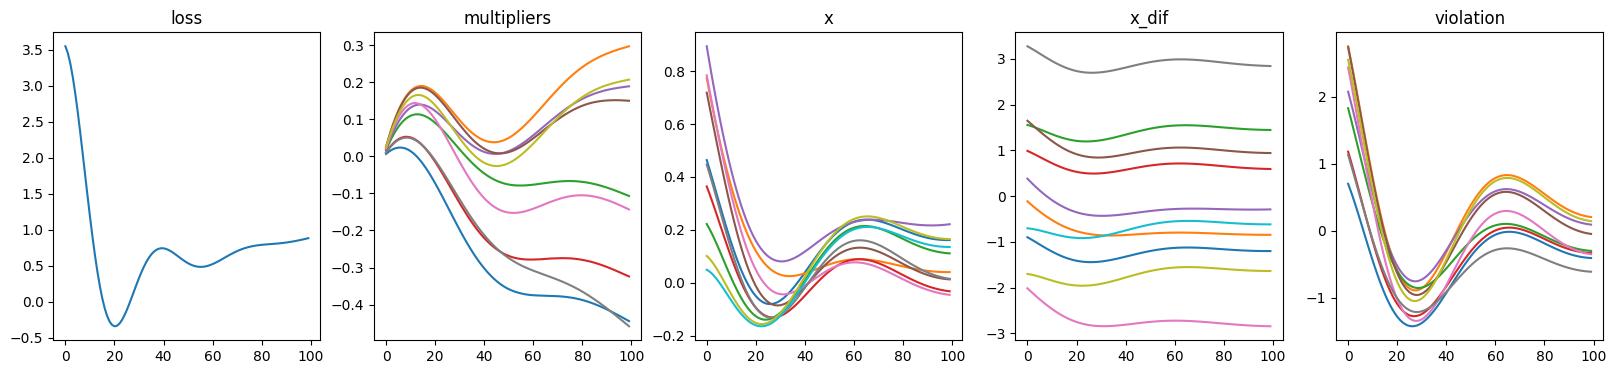

In [23]:
n_vars = 10
n_eqs = 9
batch_size = 10
primal_lr = 3e-2
dual_lr = 9e-3

x, x_optim, eq_group, ls_loader, optimizer, cmp = prepare_data(
    n_vars, n_eqs, batch_size, primal_lr, dual_lr
)

state_history = optimization_process(100, ls_loader, optimizer, cmp, x, x_optim, eq_group)

plot_state_history(state_history)